In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr
import pandas as pd
import seaborn as sns
import dask.array as da
import dask.dataframe as ddf

import cartopy.crs as ccrs

In [2]:
dm_tprime_xr = xr.open_dataset('/project2/geos39650/jet_stream/data/demean_t_prime_1980_2020.nc4')
# tprime_xr = xr.open_dataset('/project2/geos39650/jet_stream/data/t_prime_test_blobs_no_resample_2015-12-01_2020-03-01.nc4')
weeks = 10
period = weeks*7-1
selected_dates= pd.date_range('2016-12-04',periods=period,freq='D')
dm_tprime_xr=dm_tprime_xr.sel(time=selected_dates)
dm_tprime_xr

<xarray.Dataset>
Dimensions:    (latitude: 280, longitude: 1440, time: 69)
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 20.75 20.5 20.25
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * time       (time) datetime64[ns] 2016-12-04 2016-12-05 ... 2017-02-10
    dayofyear  (time) int64 ...
Data variables:
    t_prime    (time, latitude, longitude) float64 ...

## Hovmoller

In [3]:
def hovmoller(data,lat_range):
    data_strip = data.sel({'latitude': lat_range, 'time':selected_dates})
    meaned_data_strip = data_strip.mean(dim=['latitude']).reset_coords('dayofyear',drop=True)
    meaned_data_strip.to_array().plot()

In [63]:
lat_range = np.arange(40,45.25,0.25)

data_strip = dm_tprime_xr.sel({'latitude': lat_range, 'time':selected_dates})
meaned_data_strip = data_strip.mean(dim=['latitude'])

In [64]:
meaned_data_strip= meaned_data_strip.reset_coords('dayofyear',drop=True)

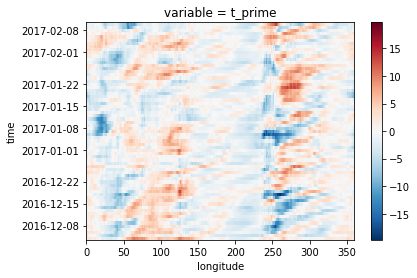

In [66]:
# ax,fig = plt.subplots(figsize=(36,10))
meaned_data_strip.to_array().plot()

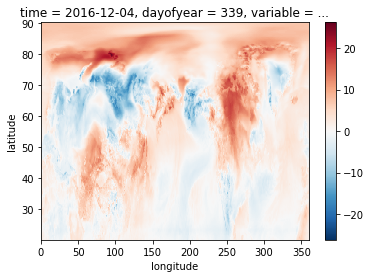

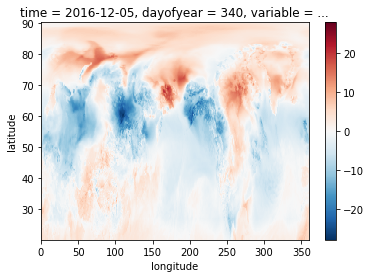

In [58]:
# fig,ax = plt.subplots(figsize=(360,5))
dm_tprime_xr.isel(time=0).to_array().plot()
plt.show()
dm_tprime_xr.isel(time=1).to_array().plot()